# Projeto de Aprendizado Descritivo: Descoberta de Padrões em Apartamentos para Aluguel nos EUA

## Grupo:
Alexis Duarte Guimarães Marim

Bernnardo Seraphim Baptista de Oliveira

Gabriel Castelo Branco Rocha Alencar Pinto

Henrique Rotsen Santos Ferreira

Luisa Vasconcelos de Castro Toledo

## Leitura e pré-processamento dos dados

In [45]:
!pip install pysubgroup
!pip install apriori_python
!pip install -U scikit-mine
!pip install mlxtend

In [46]:
import warnings
import pandas as pd
import numpy as np
import pysubgroup as ps
import matplotlib.pyplot as plt

from skmine.itemsets import LCM
from skmine.itemsets import SLIM
from pysubgroup import SubgroupDiscoveryTask, Conjunction, BinaryTarget

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [47]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adithyaawati/apartments-for-rent-classified")

print("Path to dataset files:", path)
csv = "/kaggle/input/apartments-for-rent-classified/apartments_for_rent_classified_100K/apartments_for_rent_classified_100K.csv"
df = pd.read_csv(csv, delimiter=";", encoding="windows-1252")

Path to dataset files: /kaggle/input/apartments-for-rent-classified


/tmp/ipython-input-47-928184488.py:8: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv, delimiter=";", encoding="windows-1252")


In [48]:
# Convert 'amenities' column to string, coercing errors to NaN
df_filtered = df.copy()
df_filtered['amenities'] = df_filtered['amenities'].astype(str)

# Remove rows where 'amenities' is 'nan' (from conversion of NaN) or just whitespace
df_filtered = df_filtered[
    (df_filtered['amenities'].str.strip() != '') &
    (df_filtered['amenities'].str.lower() != 'nan')
].copy()

# Initialize a set to store all unique amenities
all_amenities = set()

# Populate the set with all unique amenities
for index, row in df_filtered.iterrows():
    # Split the string by comma and remove leading/trailing whitespace from each amenity
    amenities_list = [amenity.strip().lower() for amenity in row['amenities'].split(',')]
    all_amenities.update(amenities_list)

# Now, create new columns for each amenity with 0s or 1s
for amenity in all_amenities:
    df_filtered[amenity] = df_filtered['amenities'].apply(lambda x: 1 if amenity in [a.strip().lower() for a in x.split(',')] else 0)

# Finally, drop the original 'amenities' column
df = df_filtered.drop('amenities', axis=1)

In [49]:
df.head()

,id,category,title,body,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time,parking,tv,gated,pool,golf,cable or satellite,alarm,hot tub,fireplace,patio/deck,gym,storage,internet access,playground,ac,washer dryer,doorman,view,clubhouse,basketball,garbage disposal,wood floors,refrigerator,elevator,tennis,dishwasher,luxury
21,5668632369,housing/rent/apartment,One BR 7011 W PARMER LN,"This unit is located at 7011 W PARMER LN, Austin, 78729, TXMonthly rental rates range from $1060 - $1910We have one - four beds units available for rent",1.0,1.0,USD,No,Thumbnail,NaN,1060.0,"$1,060",Monthly,650,7011 W Parmer Lane,Austin,TX,30.3054,-97.7497,RentLingo,1577359827,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
22,5668632002,housing/rent/apartment,One BR 2800 SUNRISE RD,"This unit is located at 2800 SUNRISE RD, Round Rock, 78664, TXMonthly rental rates range from $1003 - $1529We have one - three beds units available for rent",1.0,1.0,USD,No,Thumbnail,NaN,1003.0,"$1,003",Monthly,797,2800 Sunrise Road,Round Rock,TX,30.5118,-97.6873,RentLingo,1577359796,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,5668631854,housing/rent/apartment,One BR 12330 METRIC BLVD.,"This unit is located at 12330 METRIC BLVD., Austin, 78758, TXMonthly rental rates range from $837 - $1356We have one - two beds units available for rent",1.0,1.0,USD,No,Thumbnail,NaN,837.0,$837,Monthly,444,12330 Metric Boulevard,Austin,TX,30.3054,-97.7497,RentLingo,1577359784,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
24,5668631790,housing/rent/apartment,One BR 8021 FM 620 NORTH,"This unit is located at 8021 FM 620 NORTH, Austin, 78726, TXMonthly rental rates range from $1020 - $1550We have one - three beds units available for rent",1.0,1.0,USD,No,Thumbnail,NaN,1020.0,"$1,020",Monthly,692,8021 Fm 620 North,Austin,TX,30.3054,-97.7497,RentLingo,1577359778,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
25,5668631784,housing/rent/apartment,One BR 11500 JOLLYVILLE RD.,"This unit is located at 11500 JOLLYVILLE RD., Austin, 78759, TXMonthly rental rates range from $985 - $1530We have one - three beds units available for rent",1.0,1.0,USD,No,Thumbnail,NaN,985.0,$985,Monthly,693,11500 Jollyville Road,Austin,TX,30.3054,-97.7497,RentLingo,1577359777,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Filtrando transações (apenas linhas com colunas de comodidades)

In [50]:
amenities_cols = ['fireplace', 'gym', 'parking', 'pool', 'storage',
       'wood floors', 'gated', 'dishwasher', 'clubhouse', 'refrigerator',
       'elevator', 'patio/deck', 'cable or satellite', 'garbage disposal',
       'internet access', 'luxury', 'playground', 'basketball', 'hot tub',
       'tennis', 'doorman', 'tv', 'washer dryer', 'view', 'alarm', 'golf',
       'ac']

transactions = df[amenities_cols]
transactions

,fireplace,gym,parking,pool,storage,wood floors,gated,dishwasher,clubhouse,refrigerator,elevator,patio/deck,cable or satellite,garbage disposal,internet access,luxury,playground,basketball,hot tub,tennis,doorman,tv,washer dryer,view,alarm,golf,ac
21,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99487,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
99488,0,1,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1
99489,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
99490,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Removendo transações sem itens

In [51]:
transactions_with_counts = transactions.copy()
transactions_with_counts["amenities_count"] = transactions_with_counts.sum(axis=1)

not_empty_transactions = transactions_with_counts[transactions_with_counts["amenities_count"] > 0]

not_empty_transactions = not_empty_transactions.drop(columns=["amenities_count"])
not_empty_transactions.shape

(83448, 27)

In [52]:
not_empty_transactions

,fireplace,gym,parking,pool,storage,wood floors,gated,dishwasher,clubhouse,refrigerator,elevator,patio/deck,cable or satellite,garbage disposal,internet access,luxury,playground,basketball,hot tub,tennis,doorman,tv,washer dryer,view,alarm,golf,ac
21,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99487,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
99488,0,1,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1
99489,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
99490,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


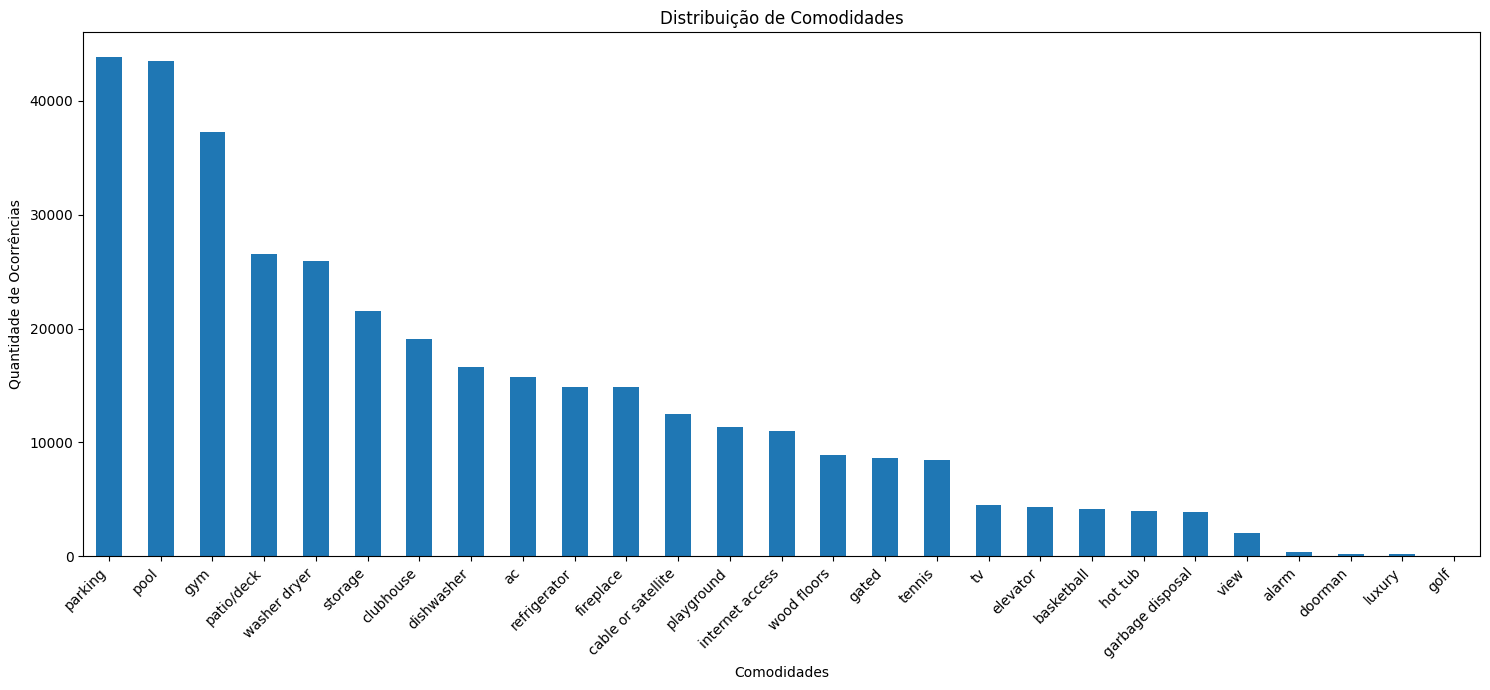

In [53]:
amenity_counts = not_empty_transactions.sum().sort_values(ascending=False)
plt.figure(figsize=(15, 7))
amenity_counts.plot(kind='bar')
plt.title('Distribuição de Comodidades')
plt.xlabel('Comodidades')
plt.ylabel('Quantidade de Ocorrências')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Closed Itemset Mining


In [54]:
lcm = LCM()
itemsets = lcm.fit_transform(not_empty_transactions)
itemsets

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,itemset,support
0,[a],17
1,[r],15
2,"[a, r]",13
3,[e],15
4,"[a, e]",12
5,"[a, e, r]",9
6,[o],13
7,"[a, o]",8
8,"[o, r]",8
9,"[a, o, r]",7


## First Itemset Mining Algorithm

In [55]:
from apriori_python import apriori
freqItemSet, rules = apriori(not_empty_transactions[:2], minSup=1, minConf=1)
freqItemSet[8]

{frozenset({' ', 'a', 'b', 'e', 'i', 'l', 'r', 's'}),
 frozenset({' ', 'b', 'e', 'i', 'l', 'o', 'r', 's'}),
 frozenset({'a', 'b', 'e', 'i', 'l', 'o', 'r', 's'}),
 frozenset({' ', 'a', 'e', 'i', 'l', 'o', 'r', 's'}),
 frozenset({' ', 'a', 'b', 'i', 'l', 'o', 'r', 's'}),
 frozenset({' ', 'a', 'b', 'e', 'i', 'o', 'r', 's'}),
 frozenset({' ', 'a', 'b', 'e', 'l', 'o', 'r', 's'}),
 frozenset({' ', 'a', 'b', 'e', 'i', 'l', 'o', 'r'}),
 frozenset({' ', 'a', 'c', 'e', 'i', 'r', 's', 't'}),
 frozenset({' ', 'a', 'b', 'e', 'i', 'l', 'o', 's'})}

## Itemset Mining Algorithm



In [56]:
from mlxtend.frequent_patterns import apriori, fpmax, association_rules

not_empty_transactions_bool = not_empty_transactions.astype(bool)
MIN_LINES = 1000
NUM_OF_LINES = not_empty_transactions_bool.shape[0]
MIN_SUPPORT = 0.1
# MIN_SUPPORT = MIN_LINES / NUM_OF_LINES

# Find frequent itemsets
frequent_itemsets = apriori(not_empty_transactions_bool, min_support=MIN_SUPPORT, use_colnames=True)
frequent_itemsets['lines'] = frequent_itemsets['support'] * NUM_OF_LINES

# Print the frequent itemsets
print(f"Minimum number of lines a set of attributes must be true in order to be considered: {MIN_SUPPORT * NUM_OF_LINES}")
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets[frequent_itemsets['length'] >= 2].sort_values(by='support', ascending=False).head(15)

Minimum number of lines a set of attributes must be true in order to be considered: 8344.800000000001


,support,itemsets,lines,length
21,0.340476,"(pool, gym)",28412.0,2
27,0.251965,"(parking, pool)",21026.0,2
20,0.213414,"(parking, gym)",17809.0,2
38,0.198099,"(pool, patio/deck)",16531.0,2
25,0.190646,"(washer dryer, gym)",15909.0,2
40,0.190538,"(washer dryer, pool)",15900.0,2
37,0.179561,"(clubhouse, pool)",14984.0,2
28,0.176865,"(storage, parking)",14759.0,2
24,0.171987,"(patio/deck, gym)",14352.0,2
23,0.170861,"(clubhouse, gym)",14258.0,2


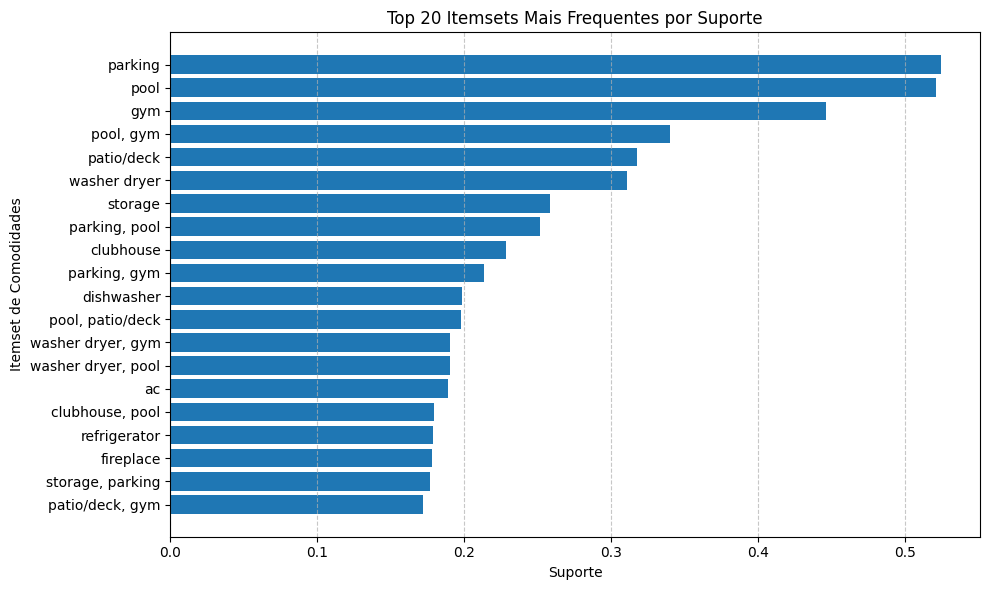

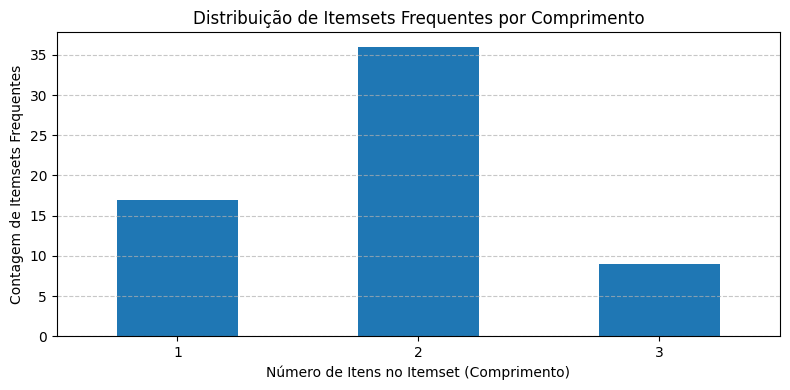

In [57]:
top_n = 20
if len(frequent_itemsets) < top_n:
    top_n = len(frequent_itemsets)

top_frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False).head(top_n)
top_frequent_itemsets['itemset_str'] = top_frequent_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))

plt.figure(figsize=(10, 6))
plt.barh(top_frequent_itemsets['itemset_str'], top_frequent_itemsets['support'])

# Configurações do gráfico
plt.xlabel('Suporte')
plt.ylabel('Itemset de Comodidades')
plt.title(f'Top {top_n} Itemsets Mais Frequentes por Suporte')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Distribuição de Itemsets por Comprimento
if not frequent_itemsets.empty:
    plt.figure(figsize=(8, 4))
    frequent_itemsets['length'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribuição de Itemsets Frequentes por Comprimento')
    plt.xlabel('Número de Itens no Itemset (Comprimento)')
    plt.ylabel('Contagem de Itemsets Frequentes')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNenhum itemset frequente encontrado com o suporte mínimo especificado. Ajuste o min_support para ver resultados.")


## Maximal itemsets

In [58]:
maximal_itemsets = fpmax(not_empty_transactions_bool, min_support=MIN_SUPPORT, use_colnames=True)
maximal_itemsets['lines'] = maximal_itemsets['support'] * NUM_OF_LINES
maximal_itemsets

,support,itemsets,lines
0,0.101512,(tennis),8471.0
1,0.103681,(gated),8652.0
2,0.106402,(wood floors),8879.0
3,0.132430,(internet access),11051.0
4,0.101956,"(playground, pool)",8508.0
5,0.149914,(cable or satellite),12510.0
6,0.102040,"(fireplace, washer dryer)",8515.0
7,0.117378,"(fireplace, gym)",9795.0
8,0.119967,"(fireplace, pool)",10011.0
9,0.102567,"(refrigerator, parking)",8559.0


## Regras de Associação

In [59]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules.sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
46,(dishwasher),(refrigerator),0.198866,0.178626,0.134719,0.677433,3.792461,1.0,0.099196,2.546366,0.919096,0.554914,0.607284,0.715813
47,(refrigerator),(dishwasher),0.178626,0.198866,0.134719,0.754193,3.792461,1.0,0.099196,3.259197,0.896448,0.554914,0.693176,0.715813
53,(ac),(dishwasher),0.189064,0.198866,0.106426,0.562908,2.830584,1.0,0.068827,1.832872,0.797493,0.378060,0.454408,0.549035
52,(dishwasher),(ac),0.198866,0.189064,0.106426,0.535161,2.830584,1.0,0.068827,1.744553,0.807251,0.378060,0.426787,0.549035
96,(washer dryer),"(gym, patio/deck)",0.310984,0.171987,0.109589,0.352395,2.048958,1.0,0.056104,1.278576,0.743012,0.293504,0.217880,0.494794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,"(washer dryer, gym)",(parking),0.190646,0.525022,0.102411,0.537180,1.023158,1.0,0.002318,1.026271,0.027966,0.166996,0.025598,0.366120
105,"(pool, washer dryer)",(parking),0.190538,0.525022,0.101057,0.530377,1.010201,1.0,0.001020,1.011404,0.012475,0.164453,0.011276,0.361429
108,(parking),"(pool, washer dryer)",0.525022,0.190538,0.101057,0.192482,1.010201,1.0,0.001020,1.002407,0.021260,0.164453,0.002401,0.361429
24,(parking),(patio/deck),0.525022,0.317587,0.168248,0.320460,1.009047,1.0,0.001508,1.004228,0.018876,0.249494,0.004210,0.425116


In [60]:
rules_sorted = rules.sort_values(by='lift', ascending=False)
if not rules_sorted.empty:
    rules_table = rules_sorted[['antecedents', 'consequents', 'lift', 'confidence', 'support']].copy()
    rules_table['antecedents'] = rules_table['antecedents'].apply(lambda x: ', '.join(list(x)))
    rules_table['consequents'] = rules_table['consequents'].apply(lambda x: ', '.join(list(x)))

    rules_table.rename(columns={'support': 'frequencia_relativa'}, inplace=True)

    print("Tabela das Regras de Associação (ordenada por Lift):")
    print(rules_table)
else:
    print("Nenhuma regra de associação encontrada com os critérios especificados. Ajuste o min_support ou min_threshold.")


Tabela das Regras de Associação (ordenada por Lift):
            antecedents         consequents      lift  confidence  \
46           dishwasher        refrigerator  3.792461    0.677433   
47         refrigerator          dishwasher  3.792461    0.754193   
53                   ac          dishwasher  2.830584    0.562908   
52           dishwasher                  ac  2.830584    0.535161   
96         washer dryer     gym, patio/deck  2.048958    0.352395   
..                  ...                 ...       ...         ...   
70    washer dryer, gym             parking  1.023158    0.537180   
105  pool, washer dryer             parking  1.010201    0.530377   
108             parking  pool, washer dryer  1.010201    0.192482   
24              parking          patio/deck  1.009047    0.320460   
25           patio/deck             parking  1.009047    0.529771   

     frequencia_relativa  
46              0.134719  
47              0.134719  
53              0.106426  
52        

### Análise 10 Cidades Mais Caras

In [61]:
# Função para remover outliers usando o método IQR para um grupo (cidade)
def remove_outliers_iqr_group(group, column='price'):
    Q1 = group[column].quantile(0.25)
    Q3 = group[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtra os valores dentro dos limites
    return group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]


In [62]:
df_price = df.dropna(subset=['price'])
df_price['price'] = pd.to_numeric(df_price['price'], errors='coerce')
df_price = df_price.dropna(subset=['price'])

state_prices = df_price.groupby('state')['price'].mean()
df_price_no_outliers = df_price.groupby('state', group_keys=False).apply(remove_outliers_iqr_group)
top_10_cities = ["New York", "Jersey City", "San Francisco", "Boston", "Miami", "San Jose", "Arlington", "San Diego", "Los Angeles", "Chicago"]

df_top_cities = df_price_no_outliers[df_price_no_outliers['cityname'].isin(top_10_cities)].copy()

# Select only the amenity columns for these top cities
transactions_top_cities = df_top_cities[amenities_cols].copy()

# Remove transactions with no items (amenities) in the top cities dataframe
transactions_top_cities['amenities_count'] = transactions_top_cities.sum(axis=1)
not_empty_transactions_top_cities = transactions_top_cities[transactions_top_cities['amenities_count'] > 0].drop(columns=['amenities_count'])

# Convert to boolean for apriori
not_empty_transactions_top_cities_bool = not_empty_transactions_top_cities.astype(bool)

if not_empty_transactions_top_cities_bool.empty:
    print("Não há dados de transações válidas para as 10 cidades mais caras após a filtragem de comodidades nulas.")
else:
    frequent_itemsets_top_cities = apriori(not_empty_transactions_top_cities_bool, min_support=MIN_SUPPORT, use_colnames=True)

    if frequent_itemsets_top_cities.empty:
        print(f"Nenhum itemset frequente encontrado nas 10 cidades mais caras com suporte mínimo de {MIN_SUPPORT}. Considere diminuir o min_support.")
    else:
        # Generate association rules for the top 10 cities
        rules_top_cities = association_rules(frequent_itemsets_top_cities, metric="lift", min_threshold=1.0)

        if rules_top_cities.empty:
             print("Nenhuma regra de associação encontrada nas 10 cidades mais caras com threshold de lift de 1.0. Considere diminuir o min_threshold.")
        else:
            # Sort rules by lift
            rules_top_cities_sorted = rules_top_cities.sort_values(by='lift', ascending=False)

            # Select relevant columns and format for display
            rules_table_top_cities = rules_top_cities_sorted[['antecedents', 'consequents', 'lift', 'support', 'confidence', 'leverage', 'conviction']].copy()
            rules_table_top_cities['antecedents'] = rules_table_top_cities['antecedents'].apply(lambda x: ', '.join(list(x)))
            rules_table_top_cities['consequents'] = rules_table_top_cities['consequents'].apply(lambda x: ', '.join(list(x)))

            rules_table_top_cities.rename(columns={'support': 'frequencia_relativa'}, inplace=True)

/tmp/ipython-input-62-3915783605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price['price'] = pd.to_numeric(df_price['price'], errors='coerce')


In [63]:
frequent_itemsets_top_cities['length'] = frequent_itemsets_top_cities['itemsets'].apply(lambda x: len(x))
frequent_itemsets_top_cities[frequent_itemsets_top_cities['length'] >= 2].sort_values(by='support', ascending=False).head(15)

,support,itemsets,length
17,0.260047,"(pool, gym)",2
16,0.204765,"(parking, gym)",2
22,0.189489,"(parking, pool)",2
19,0.169667,"(patio/deck, gym)",2
27,0.162939,"(parking, patio/deck)",2
30,0.156574,"(pool, patio/deck)",2
20,0.153301,"(washer dryer, gym)",2
29,0.141662,"(ac, parking)",2
28,0.136752,"(parking, washer dryer)",2
25,0.132751,"(dishwasher, parking)",2


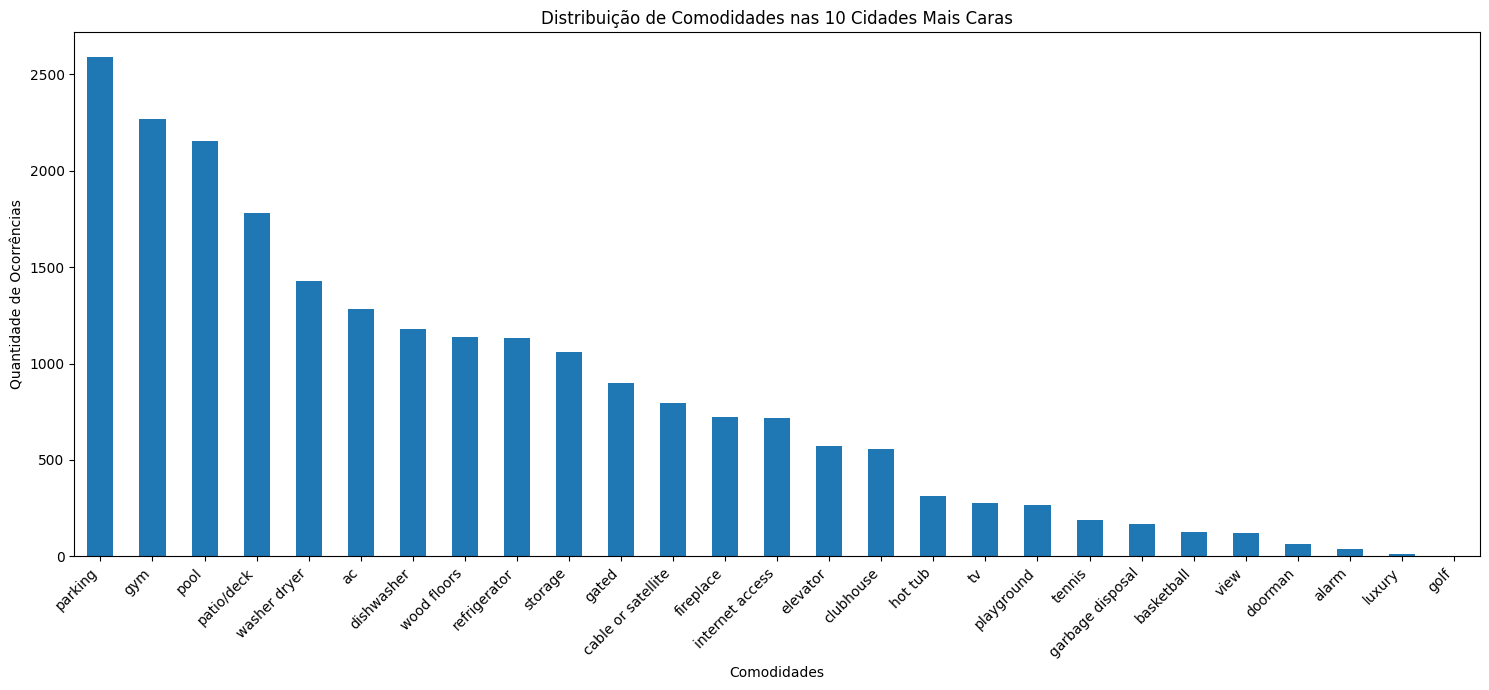

In [64]:
amenity_counts = not_empty_transactions_top_cities_bool.sum().sort_values(ascending=False)
plt.figure(figsize=(15, 7))
amenity_counts.plot(kind='bar')
plt.title('Distribuição de Comodidades nas 10 Cidades Mais Caras')
plt.xlabel('Comodidades')
plt.ylabel('Quantidade de Ocorrências')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [65]:
if not rules_top_cities_sorted.empty:
    rules_table = rules_top_cities_sorted[['antecedents', 'consequents', 'lift', 'confidence', 'support']].copy()
    rules_table['antecedents'] = rules_table['antecedents'].apply(lambda x: ', '.join(list(x)))
    rules_table['consequents'] = rules_table['consequents'].apply(lambda x: ', '.join(list(x)))
    print("Tabela das Regras de Associação (ordenada por Lift) 10 Cidades Mais Caras :")
    print(rules_table)
else:
    print("Nenhuma regra de associação encontrada com os critérios especificados. Ajuste o min_support ou min_threshold.")


Tabela das Regras de Associação (ordenada por Lift) 10 Cidades Mais Caras :
         antecedents       consequents      lift  confidence   support
35      refrigerator        dishwasher  2.983060    0.639576  0.131660
34        dishwasher      refrigerator  2.983060    0.614080  0.131660
38        dishwasher                ac  2.569804    0.600509  0.128751
39                ac        dishwasher  2.569804    0.550973  0.128751
45      washer dryer                ac  1.765093    0.412465  0.107110
44                ac      washer dryer  1.765093    0.458366  0.107110
54  pool, patio/deck               gym  1.731096    0.714286  0.111839
55               gym  pool, patio/deck  1.731096    0.271045  0.111839
56              pool   patio/deck, gym  1.681235    0.285250  0.111839
53   patio/deck, gym              pool  1.681235    0.659164  0.111839
51               gym     parking, pool  1.621117    0.307184  0.126750
46     parking, pool               gym  1.621117    0.668906  0.126750
3

### Análise 10 Cidades Mais Baratas

In [66]:
df_price = df.dropna(subset=['price'])
df_price['price'] = pd.to_numeric(df_price['price'], errors='coerce')
df_price = df_price.dropna(subset=['price'])

state_prices = df_price.groupby('state')['price'].mean()
df_price_no_outliers = df_price.groupby('state', group_keys=False).apply(remove_outliers_iqr_group)
top_10_cities = ["Lincoln", "El Paso", "Memphis", "Albuquerque", "Tucson", "Tulsa", "Oklahoma City", "Shreveport", "Wichita", "Akron"]

df_top_cities = df_price_no_outliers[df_price_no_outliers['cityname'].isin(top_10_cities)].copy()

# Select only the amenity columns for these top cities
transactions_top_cities = df_top_cities[amenities_cols].copy()

# Remove transactions with no items (amenities) in the top cities dataframe
transactions_top_cities['amenities_count'] = transactions_top_cities.sum(axis=1)
not_empty_transactions_top_cities = transactions_top_cities[transactions_top_cities['amenities_count'] > 0].drop(columns=['amenities_count'])

# Convert to boolean for apriori
not_empty_transactions_top_cities_bool = not_empty_transactions_top_cities.astype(bool)

if not_empty_transactions_top_cities_bool.empty:
    print("Não há dados de transações válidas para as 10 cidades mais caras após a filtragem de comodidades nulas.")
else:
    frequent_itemsets_top_cities = apriori(not_empty_transactions_top_cities_bool, min_support=MIN_SUPPORT, use_colnames=True)

    if frequent_itemsets_top_cities.empty:
        print(f"Nenhum itemset frequente encontrado nas 10 cidades mais caras com suporte mínimo de {MIN_SUPPORT}. Considere diminuir o min_support.")
    else:
        # Generate association rules for the top 10 cities
        rules_top_cities = association_rules(frequent_itemsets_top_cities, metric="lift", min_threshold=1.0)

        if rules_top_cities.empty:
             print("Nenhuma regra de associação encontrada nas 10 cidades mais baratas com threshold de lift de 1.0. Considere diminuir o min_threshold.")
        else:
            # Sort rules by lift
            rules_top_cities_sorted = rules_top_cities.sort_values(by='lift', ascending=False)

            # Select relevant columns and format for display
            rules_table_top_cities = rules_top_cities_sorted[['antecedents', 'consequents', 'lift', 'support', 'confidence', 'leverage', 'conviction']].copy()
            rules_table_top_cities['antecedents'] = rules_table_top_cities['antecedents'].apply(lambda x: ', '.join(list(x)))
            rules_table_top_cities['consequents'] = rules_table_top_cities['consequents'].apply(lambda x: ', '.join(list(x)))

            rules_table_top_cities.rename(columns={'support': 'frequencia_relativa'}, inplace=True)

/tmp/ipython-input-66-103018495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price['price'] = pd.to_numeric(df_price['price'], errors='coerce')


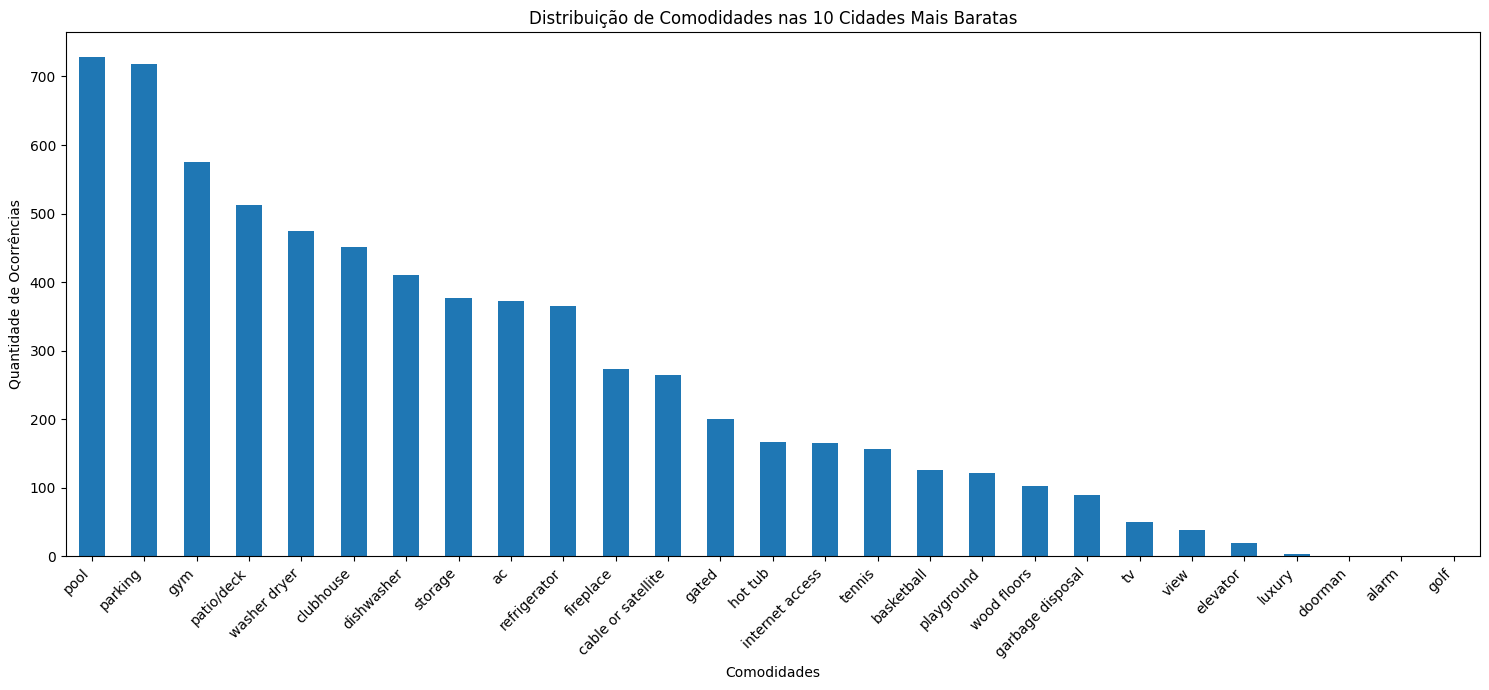

In [67]:
amenity_counts = not_empty_transactions_top_cities_bool.sum().sort_values(ascending=False)
plt.figure(figsize=(15, 7))
amenity_counts.plot(kind='bar')
plt.title('Distribuição de Comodidades nas 10 Cidades Mais Baratas')
plt.xlabel('Comodidades')
plt.ylabel('Quantidade de Ocorrências')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [68]:
if not rules_top_cities_sorted.empty:
    rules_table = rules_top_cities_sorted[['antecedents', 'consequents', 'lift', 'confidence', 'support']].copy()
    rules_table['antecedents'] = rules_table['antecedents'].apply(lambda x: ', '.join(list(x)))
    rules_table['consequents'] = rules_table['consequents'].apply(lambda x: ', '.join(list(x)))
    print("Tabela das Regras de Associação (ordenada por Lift) 10 Cidades Mais Caras :")
    print(rules_table)
else:
    print("Nenhuma regra de associação encontrada com os critérios especificados. Ajuste o min_support ou min_threshold.")


Tabela das Regras de Associação (ordenada por Lift) 10 Cidades Mais Caras :
                  antecedents               consequents      lift  confidence  \
298           dishwasher, gym                  ac, pool  3.795277    0.653153   
299                  ac, pool           dishwasher, gym  3.795277    0.596708   
303                        ac     dishwasher, pool, gym  3.074728    0.389785   
294     dishwasher, pool, gym                        ac  3.074728    0.810056   
297          dishwasher, pool                   ac, gym  3.067726    0.510563   
..                        ...                       ...       ...         ...   
25                    parking                 clubhouse  1.007270    0.321727   
193                   parking  dishwasher, refrigerator  1.003915    0.203343   
188  dishwasher, refrigerator                   parking  1.003915    0.510490   
35                       pool                   storage  1.003221    0.267857   
34                    storage    

## Descoberta de Subgrupos



In [69]:
from pysubgroup import BeamSearch

In [70]:
df = pd.read_csv(csv, delimiter=";", encoding="windows-1252")

/tmp/ipython-input-70-1464618028.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv, delimiter=";", encoding="windows-1252")


In [71]:
capitais_eua = [
    "Montgomery", "Juneau", "Phoenix", "Little Rock", "Sacramento",
    "Denver", "Hartford", "Dover", "Tallahassee", "Atlanta",
    "Honolulu", "Boise", "Springfield", "Indianapolis", "Des Moines",
    "Topeka", "Frankfort", "Baton Rouge", "Augusta", "Annapolis",
    "Boston", "Lansing", "Saint Paul", "Jackson", "Jefferson City",
    "Helena", "Lincoln", "Carson City", "Concord", "Trenton",
    "Santa Fe", "Albany", "Raleigh", "Bismarck", "Columbus",
    "Oklahoma City", "Salem", "Harrisburg", "Providence", "Columbia",
    "Pierre", "Nashville", "Austin", "Salt Lake City", "Montpelier",
    "Richmond", "Olympia", "Charleston", "Madison", "Cheyenne"
]

In [72]:
# Pré-processamento e Feature Engineering

# Filtrar NaN em colunas essenciais para o SD
df.dropna(subset=['price', 'square_feet', 'bathrooms', 'bedrooms', 'cityname', 'state', 'bathrooms', 'bedrooms'], inplace=True)

# Descoberta de Subgrupos

print("\n--- Iniciando a Descoberta de Subgrupos ---")

# Atributos Categóricos:
attributes1 = ['state', 'bathrooms', 'bedrooms', 'square_feet']

ignore1 = list(set(list(df)) - set(attributes1))
search_space = ps.create_selectors(df, ignore=ignore1)

# Tarefa 1: Encontrar subgrupos com PREÇO MÉDIO ALTO
target_price_high = ps.NumericTarget('price')
task_price_high = SubgroupDiscoveryTask(
    data=df,
    target=target_price_high,
    result_set_size=20,
    search_space=search_space,
    qf=ps.StandardQFNumeric(a=0.5),
)

print("\nBuscando subgrupos para 'Preço Médio Alto'...")
result_price_high = ps.BeamSearch().execute(task_price_high)


--- Iniciando a Descoberta de Subgrupos ---

Buscando subgrupos para 'Preço Médio Alto'...


In [73]:
df_result = result_price_high.to_dataframe()
print("\n--- Top Subgrupos para Preço Médio Alto ---")
for i, sg in df_result.iterrows():
    quality = sg['quality']
    subgroup = sg['subgroup']
    size = sg['size_sg']
    mean = sg['mean_sg']

    print(f"\nSubgrupo {i+1}: {subgroup}")
    print(f"  Qualidade: {quality:.4f}")
    print(f"  Tamanho: {size} apartamentos")
    print(f"  Média do Preço no Subgrupo: {mean}")
    print(f"  Média do Preço Global: {df['price'].mean():.2f}")


--- Top Subgrupos para Preço Médio Alto ---

Subgrupo 1: square_feet>=1165 AND state=='CA'
  Qualidade: 99413.9916
  Tamanho: 1580 apartamentos
  Média do Preço no Subgrupo: 4026.676582278481
  Média do Preço Global: 1525.65

Subgrupo 2: state=='CA'
  Qualidade: 95186.3132
  Tamanho: 10254 apartamentos
  Média do Preço no Subgrupo: 2465.646186853911
  Média do Preço Global: 1525.65

Subgrupo 3: bathrooms>=2.50 AND square_feet>=1165 AND state=='CA'
  Qualidade: 85313.0787
  Tamanho: 477 apartamentos
  Média do Preço no Subgrupo: 5431.863731656184
  Média do Preço Global: 1525.65

Subgrupo 4: bathrooms>=2.50 AND state=='CA'
  Qualidade: 83832.9262
  Tamanho: 524 apartamentos
  Média do Preço no Subgrupo: 5187.904580152672
  Média do Preço Global: 1525.65

Subgrupo 5: bathrooms: [2.0:2.50[ AND state=='CA'
  Qualidade: 72503.3875
  Tamanho: 3519 apartamentos
  Média do Preço no Subgrupo: 2747.8641659562377
  Média do Preço Global: 1525.65

Subgrupo 6: bedrooms: [2.0:3.0[ AND state=='CA'
 

In [74]:
# Atributos Categóricos:
attributes2 = ['state', 'bathrooms', 'bedrooms', 'price']

ignore2 = list(set(list(df)) - set(attributes2))
search_space = ps.create_selectors(df, ignore=ignore2)

# Tarefa 2: Encontrar subgrupos com ÁREA MÉDIA ALTA
target_sqft_high = ps.NumericTarget('square_feet')
task_sqft_high = SubgroupDiscoveryTask(
    data=df,
    target=target_sqft_high,
    search_space=search_space,
    result_set_size=20,
    qf=ps.StandardQFNumeric(a=0.5),
)
print("\nBuscando subgrupos para 'Área Média Alta'...")
result_sqft_high = ps.BeamSearch().execute(task_sqft_high)


Buscando subgrupos para 'Área Média Alta'...


In [75]:
df_result.head()

,quality,subgroup,size_sg,size_dataset,mean_sg,mean_dataset,std_sg,std_dataset,median_sg,median_dataset,max_sg,max_dataset,min_sg,min_dataset,mean_lift,median_lift
0,99413.991591,square_feet>=1165 AND state=='CA',1580,99007,4026.676582,1525.646197,3485.098289,898.950744,3304.5,1350.0,52500.0,52500.0,900.0,100.0,2.639325,2.447778
1,95186.313152,state=='CA',10254,99007,2465.646187,1525.646197,1690.916414,898.950744,2198.0,1350.0,52500.0,52500.0,493.0,100.0,1.616132,1.628148
2,85313.078719,bathrooms>=2.50 AND square_feet>=1165 AND state=='CA',477,99007,5431.863732,1525.646197,5152.784215,898.950744,3975.0,1350.0,40000.0,52500.0,975.0,100.0,3.560369,2.944444
3,83832.926163,bathrooms>=2.50 AND state=='CA',524,99007,5187.904580,1525.646197,4981.937478,898.950744,3800.0,1350.0,40000.0,52500.0,975.0,100.0,3.400464,2.814815
4,72503.387469,bathrooms: [2.0:2.50[ AND state=='CA',3519,99007,2747.864166,1525.646197,1229.445477,898.950744,2510.0,1350.0,14850.0,52500.0,725.0,100.0,1.801115,1.859259


In [76]:
df_result = result_sqft_high.to_dataframe()
print("\n--- Top 10 Subgrupos para Área Média Alta ---")
for i, sg in df_result.iterrows():
    quality = sg['quality']
    subgroup = sg['subgroup']
    size = sg['size_sg']
    mean = sg['mean_sg']
    std = sg['mean_sg']

    print(f"\nSubgrupo {i+1}: {subgroup}")
    print(f"  Qualidade: {quality:.4f}")
    print(f"  Tamanho: {size} apartamentos")
    print(f"  Média da Metragem no Subgrupo: {quality}")
    print(f"  Desvio Padrão da Metragem no Subgrupo: {quality}")
    print(f"  Média da Metragem Global: {df['square_feet'].mean():.2f}")


--- Top 10 Subgrupos para Área Média Alta ---

Subgrupo 1: bathrooms>=2.50
  Qualidade: 53968.9154
  Tamanho: 3366 apartamentos
  Média da Metragem no Subgrupo: 53968.91543121421
  Desvio Padrão da Metragem no Subgrupo: 53968.91543121421
  Média da Metragem Global: 956.07

Subgrupo 2: bedrooms>=4.0
  Qualidade: 52664.2484
  Tamanho: 1831 apartamentos
  Média da Metragem no Subgrupo: 52664.24843907705
  Desvio Padrão da Metragem no Subgrupo: 52664.24843907705
  Média da Metragem Global: 956.07

Subgrupo 3: bathrooms>=2.50 AND bedrooms>=4.0
  Qualidade: 52326.7128
  Tamanho: 977 apartamentos
  Média da Metragem no Subgrupo: 52326.71275455511
  Desvio Padrão da Metragem no Subgrupo: 52326.71275455511
  Média da Metragem Global: 956.07

Subgrupo 4: bathrooms>=2.50 AND price>=1934.0
  Qualidade: 49485.3245
  Tamanho: 1646 apartamentos
  Média da Metragem no Subgrupo: 49485.32449091257
  Desvio Padrão da Metragem no Subgrupo: 49485.32449091257
  Média da Metragem Global: 956.07

Subgrupo 5:

### Teste: normalizar o preço por cidade

In [77]:
# Carregando dataset novamente
df = pd.read_csv(csv, delimiter=";", encoding="windows-1252")

/tmp/ipython-input-77-496432433.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv, delimiter=";", encoding="windows-1252")


In [78]:
# Carregando dataset novamente
df = pd.read_csv(csv, delimiter=";", encoding="windows-1252")

# Limpeza e Tratamento de Valores Ausentes
for col in ['bathrooms', 'bedrooms']:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

# Para amenities, vamos simplificar para o SD, tratando como categorias ou binarizando
# Criar colunas binárias para algumas amenities selecionadas ou as mais comuns
# Para o SD, cada amenity individual pode ser um atributo de busca.
# Vamos pegar as 20 amenities mais comuns para não gerar atributos demais
df['amenities_list'] = df['amenities'].apply(lambda x: [item.strip() for item in str(x).split(',') if item.strip()] if pd.notna(x) else [])

# Flatten list of all amenities to count them
all_amenities = [item for sublist in df['amenities_list'] for item in sublist]
amenity_counts = pd.Series(all_amenities).value_counts()
top_amenities = amenity_counts.head(20).index.tolist() # Pegar as 20 mais comuns

# Criar colunas binárias para as top amenities
for amenity in top_amenities:
    df[f'amenity_{amenity.replace(" ", "_").replace("-", "_")}'] = df['amenities_list'].apply(lambda x: 1 if amenity in x else 0)

# Filtrar NaN em colunas essenciais para o SD
df.dropna(subset=['price', 'square_feet', 'bathrooms', 'bedrooms', 'cityname', 'state'], inplace=True)

# Descoberta de Subgrupos

print("\n--- Iniciando a Descoberta de Subgrupos (Subgroup Discovery) ---")

# Atributos Categóricos:
attributes = ['state', 'pets_allowed'] + [f'amenity_{a.replace(" ", "_").replace("-", "_")}' for a in top_amenities]
attributes.append('bathrooms')
attributes.append("bedrooms")

ignore = list(set(list(df)) - set(attributes))
search_space = ps.create_selectors(df, ignore=ignore)

# Definir as Tarefas de Descoberta de Subgrupos

# Tarefa 1: Encontrar subgrupos com PREÇO MÉDIO ALTO

#2 formas de normalização:

# Fica no mesmo intervalo de unidades do preço (útil para interpretação).
# Exemplo: se a média em Los Angeles for 2500 e um apartamento custa 2700, o valor será +200.
df['preco_normalizado_desvio'] = df['price'] - df.groupby('cityname')['price'].transform('mean')

# Produz um fator multiplicativo: 1.0 é a média da cidade.
df['preco_normalizado_relativo'] = df['price'] / df.groupby('cityname')['price'].transform('mean')
df.drop(columns=['price'], inplace=True)

target_price_high = ps.NumericTarget('preco_normalizado_desvio')

task_price_high = SubgroupDiscoveryTask(
    data=df,
    target=target_price_high,
    result_set_size=20,
    search_space=search_space,
    depth=2,
    qf=ps.StandardQFNumeric(a=0.5),
)

print("\nBuscando subgrupos para 'Preço Médio Alto'...")
result_price_high = ps.BeamSearch().execute(task_price_high)

df_result = result_price_high.to_dataframe()
print("\n--- Top  Subgrupos para Preço Médio Alto ---")
for i, sg in df_result.iterrows():
    quality = sg['quality']
    subgroup = sg['subgroup']
    size = sg['size_sg']
    mean = sg['mean_sg']

    print(f"\nSubgrupo {i+1}: {subgroup}")
    print(f"  Qualidade: {quality:.4f}")
    print(f"  Tamanho: {size} apartamentos")
    print(f"  Média da Metragem no Subgrupo: {quality}")
    print(f"  Média do Preço no Subgrupo: {mean}")
    #print(f"  Média do Preço Global: {df['price'].mean():.2f}")

/tmp/ipython-input-78-44140762.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv, delimiter=";", encoding="windows-1252")



--- Iniciando a Descoberta de Subgrupos (Subgroup Discovery) ---

Buscando subgrupos para 'Preço Médio Alto'...

--- Top  Subgrupos para Preço Médio Alto ---

Subgrupo 1: bathrooms>=2.50 AND state=='CA'
  Qualidade: 54578.0252
  Tamanho: 526 apartamentos
  Média da Metragem no Subgrupo: 54578.02519709465
  Média do Preço no Subgrupo: 2379.714985336435

Subgrupo 2: amenity_Elevator==1 AND bedrooms>=4.0
  Qualidade: 52235.9827
  Tamanho: 32 apartamentos
  Média da Metragem no Subgrupo: 52235.98274685934
  Média do Preço no Subgrupo: 9234.104405561935

Subgrupo 3: amenity_Playground==0 AND bathrooms>=2.50
  Qualidade: 52113.6112
  Tamanho: 3109 apartamentos
  Média da Metragem no Subgrupo: 52113.61124188856
  Média do Preço no Subgrupo: 934.63234759745

Subgrupo 4: bathrooms>=2.50
  Qualidade: 51485.7195
  Tamanho: 3370 apartamentos
  Média da Metragem no Subgrupo: 51485.71949727696
  Média do Preço no Subgrupo: 886.8942429990021

Subgrupo 5: amenity_Basketball==0 AND bathrooms>=2.50
  Q

In [79]:
target_price_high = ps.NumericTarget('preco_normalizado_relativo')

task_price_high = SubgroupDiscoveryTask(
    data=df,
    target=target_price_high,
    result_set_size=20,
    search_space=search_space,
    depth=2,
    qf=ps.StandardQFNumeric(a=0.5),
)

print("\nBuscando subgrupos para 'Preço Médio Alto'...")
result_price_high = ps.BeamSearch().execute(task_price_high)

df_result = result_price_high.to_dataframe()
print("\n--- Top  Subgrupos para Preço Médio Alto ---")
for i, sg in df_result.iterrows():
    quality = sg['quality']
    subgroup = sg['subgroup']
    size = sg['size_sg']
    mean = sg['mean_sg']

    print(f"\nSubgrupo {i+1}: {subgroup}")
    print(f"  Qualidade: {quality:.4f}")
    print(f"  Tamanho: {size} apartamentos")
    print(f"  Média da Metragem no Subgrupo: {quality}")
    #print(f"  Média da Metragem Global: {df['square_feet'].mean():.2f}")
    print(f"  Média do Preço no Subgrupo: {mean}")
    print(f"  Média Global (normalizada): {df['preco_normalizado_relativo'].mean():.2f}")
    #print(f"  Média do Preço Global: {df['price'].mean():.2f}")


Buscando subgrupos para 'Preço Médio Alto'...

--- Top  Subgrupos para Preço Médio Alto ---

Subgrupo 1: amenity_Playground==0 AND bathrooms: [2.0:2.50[
  Qualidade: 28.1115
  Tamanho: 31840 apartamentos
  Média da Metragem no Subgrupo: 28.11146558332225
  Média do Preço no Subgrupo: 1.1575422190804299
  Média Global (normalizada): 1.00

Subgrupo 2: amenity_Tennis==0 AND bathrooms: [2.0:2.50[
  Qualidade: 27.5922
  Tamanho: 32866 apartamentos
  Média da Metragem no Subgrupo: 27.59224382125665
  Média do Preço no Subgrupo: 1.1521996289283725
  Média Global (normalizada): 1.00

Subgrupo 3: amenity_Playground==0 AND bathrooms>=2.50
  Qualidade: 27.2442
  Tamanho: 3109 apartamentos
  Média da Metragem no Subgrupo: 27.24418687150335
  Média do Preço no Subgrupo: 1.488611280763241
  Média Global (normalizada): 1.00

Subgrupo 4: amenity_Basketball==0 AND bathrooms: [2.0:2.50[
  Qualidade: 27.1033
  Tamanho: 34930 apartamentos
  Média da Metragem no Subgrupo: 27.10326363136783
  Média do Preç

### Teste: separar os imóveis mais caros e os mais baratos

In [80]:
df = pd.read_csv(csv, delimiter=";", encoding="windows-1252")

cheap_threshold = df['price'].quantile(0.10)
expensive_threshold = df['price'].quantile(0.90)

df_cheap = df[df['price'] <= cheap_threshold]
df_expensive = df[df['price'] >= expensive_threshold]

/tmp/ipython-input-80-1381948437.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv, delimiter=";", encoding="windows-1252")


#### Imóveis mais baratos

In [81]:
df = df_cheap

# Filtrar NaN em colunas essenciais para o SD
df.dropna(subset=['price', 'square_feet', 'bathrooms', 'bedrooms', 'cityname', 'state', 'bathrooms', 'bedrooms'], inplace=True)

# Descoberta de Subgrupos

print("\n--- Iniciando a Descoberta de Subgrupos ---")

# Atributos Categóricos:
attributes1 = ['state', 'bathrooms', 'bedrooms', 'square_feet']

ignore1 = list(set(list(df)) - set(attributes1))
search_space = ps.create_selectors(df, ignore=ignore1)

# Tarefa 1: Encontrar subgrupos com PREÇO MÉDIO ALTO
target_price_high = ps.NumericTarget('price')
task_price_high = SubgroupDiscoveryTask(
    data=df,
    target=target_price_high,
    result_set_size=10,
    search_space=search_space,
    qf=ps.StandardQFNumeric(a=0.01),
)

print("\nBuscando subgrupos para 'Preço Médio Alto'...")
result_price_high = ps.BeamSearch().execute(task_price_high)


--- Iniciando a Descoberta de Subgrupos ---

Buscando subgrupos para 'Preço Médio Alto'...


In [82]:
df_result = result_price_high.to_dataframe()
print("\n--- Top Subgrupos para Preço Médio Alto ---")
for i, sg in df_result.iterrows():
    quality = sg['quality']
    subgroup = sg['subgroup']
    size = sg['size_sg']
    mean = sg['mean_sg']

    print(f"\nSubgrupo {i+1}: {subgroup}")
    print(f"  Qualidade: {quality:.4f}")
    print(f"  Tamanho: {size} apartamentos")
    print(f"  Média do Preço no Subgrupo: {mean}")
    print(f"  Média do Preço Global: {df['price'].mean():.2f}")


--- Top Subgrupos para Preço Médio Alto ---

Subgrupo 1: square_feet>=900 AND state=='MA'
  Qualidade: 118.7858
  Tamanho: 2 apartamentos
  Média do Preço no Subgrupo: 800.0
  Média do Preço Global: 682.03

Subgrupo 2: square_feet>=900 AND state=='DE'
  Qualidade: 118.7858
  Tamanho: 2 apartamentos
  Média do Preço no Subgrupo: 800.0
  Média do Preço Global: 682.03

Subgrupo 3: square_feet: [760:900[ AND state=='NH'
  Qualidade: 118.7858
  Tamanho: 2 apartamentos
  Média do Preço no Subgrupo: 800.0
  Média do Preço Global: 682.03

Subgrupo 4: bedrooms==1.0 AND square_feet: [760:900[ AND state=='NH'
  Qualidade: 118.7858
  Tamanho: 2 apartamentos
  Média do Preço no Subgrupo: 800.0
  Média do Preço Global: 682.03

Subgrupo 5: bathrooms: [2.0:2.50[ AND square_feet>=900 AND state=='CO'
  Qualidade: 118.7858
  Tamanho: 2 apartamentos
  Média do Preço no Subgrupo: 800.0
  Média do Preço Global: 682.03

Subgrupo 6: bathrooms: [1.0:1.50[ AND square_feet>=900 AND state=='MA'
  Qualidade: 118.

In [83]:
# Tarefa 2: Encontrar subgrupos com ÁREA MÉDIA ALTA
target_sqft_high = ps.NumericTarget('square_feet')
task_sqft_high = SubgroupDiscoveryTask(
    data=df,
    target=target_sqft_high,
    search_space=search_space,
    result_set_size=10,
    qf=ps.StandardQFNumeric(a=2),
)
print("\nBuscando subgrupos para 'Área Média Alta'...")
result_sqft_high = ps.BeamSearch().execute(task_sqft_high)


Buscando subgrupos para 'Área Média Alta'...


In [84]:
df_result = result_sqft_high.to_dataframe()
print("\n--- Top Subgrupos para Área Média Alta ---")
for i, sg in df_result.iterrows():
    quality = sg['quality']
    subgroup = sg['subgroup']
    size = sg['size_sg']
    mean = sg['mean_sg']

    print(f"\nSubgrupo {i+1}: {subgroup}")
    print(f"  Qualidade: {quality:.4f}")
    print(f"  Tamanho: {size} apartamentos")
    print(f"  Média da Metragem no Subgrupo: {quality}")
    print(f"  Média da Metragem Global: {df['square_feet'].mean():.2f}")


--- Top Subgrupos para Área Média Alta ---

Subgrupo 1: bedrooms==2.0
  Qualidade: 1722726158.9851
  Tamanho: 3926 apartamentos
  Média da Metragem no Subgrupo: 1722726158.985052
  Média da Metragem Global: 734.77

Subgrupo 2: square_feet>=900
  Qualidade: 1350657162.8009
  Tamanho: 2080 apartamentos
  Média da Metragem no Subgrupo: 1350657162.8009448
  Média da Metragem Global: 734.77

Subgrupo 3: bedrooms==2.0 AND square_feet>=900
  Qualidade: 661389744.1637
  Tamanho: 1564 apartamentos
  Média da Metragem no Subgrupo: 661389744.1636506
  Média da Metragem Global: 734.77

Subgrupo 4: bathrooms: [1.0:1.50[ AND bedrooms==2.0
  Qualidade: 471453170.1023
  Tamanho: 2648 apartamentos
  Média da Metragem no Subgrupo: 471453170.1022819
  Média da Metragem Global: 734.77

Subgrupo 5: square_feet: [760:900[
  Qualidade: 355368240.7553
  Tamanho: 2000 apartamentos
  Média da Metragem no Subgrupo: 355368240.755311
  Média da Metragem Global: 734.77

Subgrupo 6: bathrooms: [1.0:1.50[ AND square

#### Imóveis mais caros

In [85]:
df = df_expensive

# Filtrar NaN em colunas essenciais para o SD
df.dropna(subset=['price', 'square_feet', 'bathrooms', 'bedrooms', 'cityname', 'state', 'bathrooms', 'bedrooms'], inplace=True)

# Descoberta de Subgrupos

print("\n--- Iniciando a Descoberta de Subgrupos ---")

# Atributos Categóricos:
attributes1 = ['state', 'bathrooms', 'bedrooms', 'square_feet']

ignore1 = list(set(list(df)) - set(attributes1))
search_space = ps.create_selectors(df, ignore=ignore1)

# Tarefa 1: Encontrar subgrupos com PREÇO MÉDIO ALTO
target_price_high = ps.NumericTarget('price')
task_price_high = SubgroupDiscoveryTask(
    data=df,
    target=target_price_high,
    result_set_size=10,
    search_space=search_space,
    qf=ps.StandardQFNumeric(a=0.01),
)

print("\nBuscando subgrupos para 'Preço Médio Alto'...")
result_price_high = ps.BeamSearch().execute(task_price_high)


--- Iniciando a Descoberta de Subgrupos ---

Buscando subgrupos para 'Preço Médio Alto'...


In [86]:
df_result = result_price_high.to_dataframe()
print("\n--- Top Subgrupos para Preço Médio Alto ---")
for i, sg in df_result.iterrows():
    quality = sg['quality']
    subgroup = sg['subgroup']
    size = sg['size_sg']
    mean = sg['mean_sg']

    print(f"\nSubgrupo {i+1}: {subgroup}")
    print(f"  Qualidade: {quality:.4f}")
    print(f"  Tamanho: {size} apartamentos")
    print(f"  Média do Preço no Subgrupo: {mean}")
    print(f"  Média do Preço Global: {df['price'].mean():.2f}")


--- Top Subgrupos para Preço Médio Alto ---

Subgrupo 1: bedrooms<1.0 AND square_feet: [1181:1419[
  Qualidade: 24476.9376
  Tamanho: 2 apartamentos
  Média do Preço no Subgrupo: 27614.0
  Média do Preço Global: 3306.14

Subgrupo 2: bedrooms<1.0 AND square_feet: [1181:1419[ AND state=='CA'
  Qualidade: 24476.9376
  Tamanho: 2 apartamentos
  Média do Preço no Subgrupo: 27614.0
  Média do Preço Global: 3306.14

Subgrupo 3: bathrooms: [1.0:2.0[ AND bedrooms<1.0 AND square_feet: [1181:1419[
  Qualidade: 24476.9376
  Tamanho: 2 apartamentos
  Média do Preço no Subgrupo: 27614.0
  Média do Preço Global: 3306.14

Subgrupo 4: bathrooms: [2.50:3.0[ AND square_feet: [819:1040[ AND state=='NY'
  Qualidade: 9971.8631
  Tamanho: 1 apartamentos
  Média do Preço no Subgrupo: 13278.0
  Média do Preço Global: 3306.14

Subgrupo 5: bedrooms: [2.0:3.0[ AND square_feet>=1419 AND state=='NH'
  Qualidade: 9193.8631
  Tamanho: 1 apartamentos
  Média do Preço no Subgrupo: 12500.0
  Média do Preço Global: 3306

In [87]:
# Tarefa 2: Encontrar subgrupos com ÁREA MÉDIA ALTA
target_sqft_high = ps.NumericTarget('square_feet')
task_sqft_high = SubgroupDiscoveryTask(
    data=df,
    target=target_sqft_high,
    search_space=search_space,
    result_set_size=10,
    qf=ps.StandardQFNumeric(a=2),
)
print("\nBuscando subgrupos para 'Área Média Alta'...")
result_sqft_high = ps.BeamSearch().execute(task_sqft_high)


Buscando subgrupos para 'Área Média Alta'...


In [88]:
df_result = result_sqft_high.to_dataframe()
print("\n--- Top Subgrupos para Área Média Alta ---")
for i, sg in df_result.iterrows():
    quality = sg['quality']
    subgroup = sg['subgroup']
    size = sg['size_sg']
    mean = sg['mean_sg']

    print(f"\nSubgrupo {i+1}: {subgroup}")
    print(f"  Qualidade: {quality:.4f}")
    print(f"  Tamanho: {size} apartamentos")
    print(f"  Média da Metragem no Subgrupo: {quality}")
    print(f"  Média da Metragem Global: {df['square_feet'].mean():.2f}")


--- Top Subgrupos para Área Média Alta ---

Subgrupo 1: square_feet>=1419
  Qualidade: 3286994745.5043
  Tamanho: 1970 apartamentos
  Média da Metragem no Subgrupo: 3286994745.5042696
  Média da Metragem Global: 1218.48

Subgrupo 2: bedrooms: [3.0:4.0[
  Qualidade: 725798734.0117
  Tamanho: 1511 apartamentos
  Média da Metragem no Subgrupo: 725798734.0116918
  Média da Metragem Global: 1218.48

Subgrupo 3: bedrooms>=4.0
  Qualidade: 560801318.7096
  Tamanho: 634 apartamentos
  Média da Metragem no Subgrupo: 560801318.7096381
  Média da Metragem Global: 1218.48

Subgrupo 4: bathrooms>=3.0
  Qualidade: 529758625.7995
  Tamanho: 606 apartamentos
  Média da Metragem no Subgrupo: 529758625.79951197
  Média da Metragem Global: 1218.48

Subgrupo 5: bedrooms>=4.0 AND square_feet>=1419
  Qualidade: 489100117.9328
  Tamanho: 553 apartamentos
  Média da Metragem no Subgrupo: 489100117.93279785
  Média da Metragem Global: 1218.48

Subgrupo 6: bathrooms>=3.0 AND square_feet>=1419
  Qualidade: 4785